# Fetching the Dataset

In [7]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d shawon10/ckplus
!ls

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 131MB/s]
ckplus.zip  kaggle.json  sample_data


In [9]:
!unzip ckplus.zip
!ls

Archive:  ckplus.zip
  inflating: CK+48/anger/S010_004_00000017.png  
  inflating: CK+48/anger/S010_004_00000018.png  
  inflating: CK+48/anger/S010_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000020.png  
  inflating: CK+48/anger/S011_004_00000021.png  
  inflating: CK+48/anger/S014_003_00000028.png  
  inflating: CK+48/anger/S014_003_00000029.png  
  inflating: CK+48/anger/S014_003_00000030.png  
  inflating: CK+48/anger/S022_005_00000030.png  
  inflating: CK+48/anger/S022_005_00000031.png  
  inflating: CK+48/anger/S022_005_00000032.png  
  inflating: CK+48/anger/S026_003_00000013.png  
  inflating: CK+48/anger/S026_003_00000014.png  
  inflating: CK+48/anger/S026_003_00000015.png  
  inflating: CK+48/anger/S028_001_00000022.png  
  inflating: CK+48/anger/S028_001_00000023.png  
  inflating: CK+48/anger/S028_001_00000024.png  
  inflating: CK+48/anger/S029_001_00000017.png  
  inflating: CK+48/anger/S029_001_00000018.png  

# Imports

In [10]:
import numpy as np
import pandas as pd
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from keras.utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense , Activation , Dropout ,Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

#from keras.wrappers.scikit_learn import KerasClassifier

# Loading Images

In [11]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def preprocess_image(original_image, face_cascade, image_size=(48, 48)):

  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

  # Noise Reduction
  blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

  # Face Detection
  faces = face_cascade.detectMultiScale(blurred_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  for (x, y, w, h) in faces:
    face_image = blurred_image[y:y+h, x:x+w]
    face_image_resized = cv2.resize(face_image, image_size)

    # Normalization
    normalized_image = face_image_resized.astype('float32') / 255.0

    # Histogram Equalization
    equalized_image = cv2.equalizeHist(np.uint8(normalized_image * 255))

    return equalized_image

In [12]:
directories = os.listdir('/content/CK+48/')
img_data_list=[]

for category in directories:
    img_list=os.listdir('/content/CK+48/'+ category)
    print ('Loading images of category-'+'{}\n'.format(category))
    for img in img_list:
        input_img=cv2.imread('/content/CK+48/'+ category + '/'+ img )
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loading images of category-disgust

Loading images of category-anger

Loading images of category-fear

Loading images of category-surprise

Loading images of category-contempt

Loading images of category-happy

Loading images of category-sadness



(981, 48, 48, 3)

In [13]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [14]:
labels[0]

0

In [15]:
# Encode labels
Y = to_categorical(labels, num_classes)

In [16]:
Y[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

# CNN Model

In [17]:
x,y = shuffle(img_data,Y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [18]:
def build_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')

    return model

In [19]:
cnn_model = build_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9

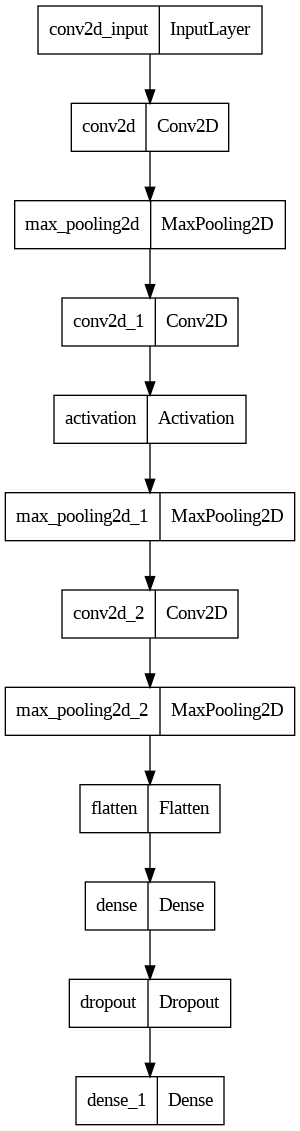

In [20]:
from keras.utils import plot_model
plot_model(cnn_model, to_file='model.png')

# k-Fold Cross Validation

In [21]:
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

kf = KFold(n_splits=5, shuffle=False)

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

In [22]:
result = []
scores_loss = []
scores_acc = []
k_no = 0

fold_histories = []
for train_index, test_index in kf.split(x):
    X_Train = x[train_index]
    Y_Train = y[train_index]
    X_Test = x[test_index]
    Y_Test = y[test_index]

    hist = cnn_model.fit(X_Train, Y_Train, batch_size=16, epochs=20, validation_data=(X_Test, Y_Test), verbose=1)
    fold_histories.append(hist)
    result.append(cnn_model.predict(X_Test))
    score = cnn_model.evaluate(X_Test,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

Epoch 1/20
49/49 [==============================] - 8s 125ms/step - loss: 1.7820 - accuracy: 0.3048 - val_loss: 1.6884 - val_accuracy: 0.4315
Epoch 2/20
49/49 [==============================] - 5s 100ms/step - loss: 1.4227 - accuracy: 0.4770 - val_loss: 1.2788 - val_accuracy: 0.5533
Epoch 3/20
49/49 [==============================] - 4s 89ms/step - loss: 1.2672 - accuracy: 0.5446 - val_loss: 1.2646 - val_accuracy: 0.5076
Epoch 4/20
49/49 [==============================] - 5s 105ms/step - loss: 1.1450 - accuracy: 0.5842 - val_loss: 1.0940 - val_accuracy: 0.5888
Epoch 5/20
49/49 [==============================] - 5s 100ms/step - loss: 1.0399 - accuracy: 0.6224 - val_loss: 1.1066 - val_accuracy: 0.6142
Epoch 6/20
49/49 [==============================] - 4s 76ms/step - loss: 0.9348 - accuracy: 0.6735 - val_loss: 1.0909 - val_accuracy: 0.5990
Epoch 7/20
49/49 [==============================] - 2s 44ms/step - loss: 0.9130 - accuracy: 0.6735 - val_loss: 0.9731 - val_accuracy: 0.6396
Epoch 8/2

In [23]:
print(scores_acc,scores_loss)

[0.7055837512016296, 0.704081654548645, 0.7193877696990967, 0.7908163070678711, 0.8469387888908386] [0.8188161849975586, 0.7117972373962402, 0.8178122639656067, 0.5885114669799805, 0.3628411591053009]


In [24]:
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

Test Loss: 0.1275494247674942
Test accuracy: 0.9441624283790588
(1, 48, 48, 3)


In [25]:
overall_results = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for fold_history in fold_histories:
    overall_results['accuracy'].append(fold_history.history['accuracy'][-1])
    overall_results['val_accuracy'].append(fold_history.history['val_accuracy'][-1])
    overall_results['loss'].append(fold_history.history['loss'][-1])
    overall_results['val_loss'].append(fold_history.history['val_loss'][-1])

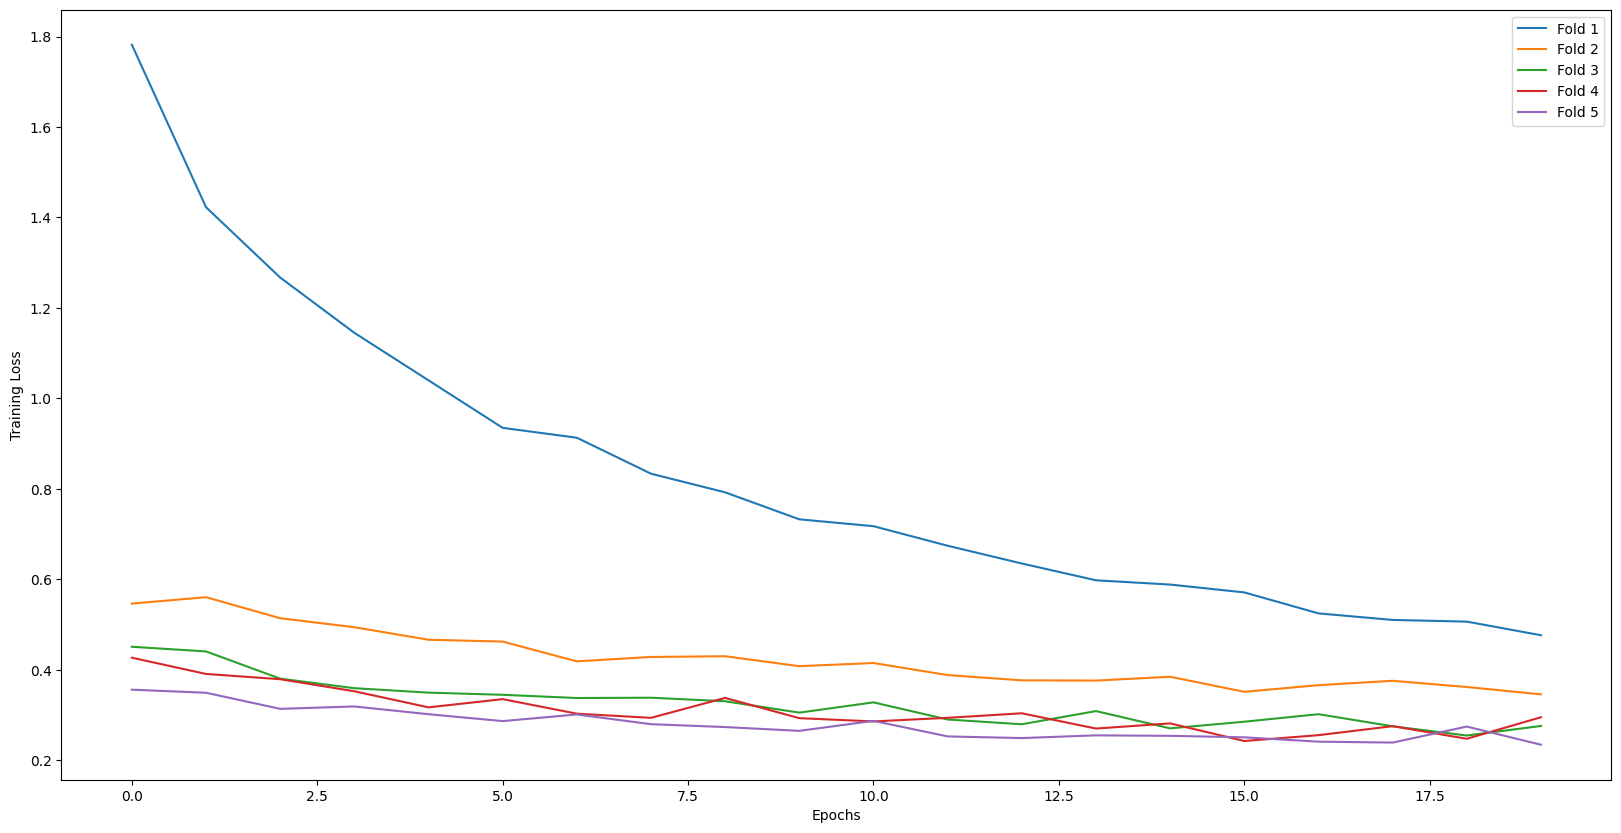

In [26]:
import matplotlib.pyplot as plt

for fold, history in enumerate(fold_histories):
    plt.plot(history.history['loss'], label=f'Fold {fold + 1}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

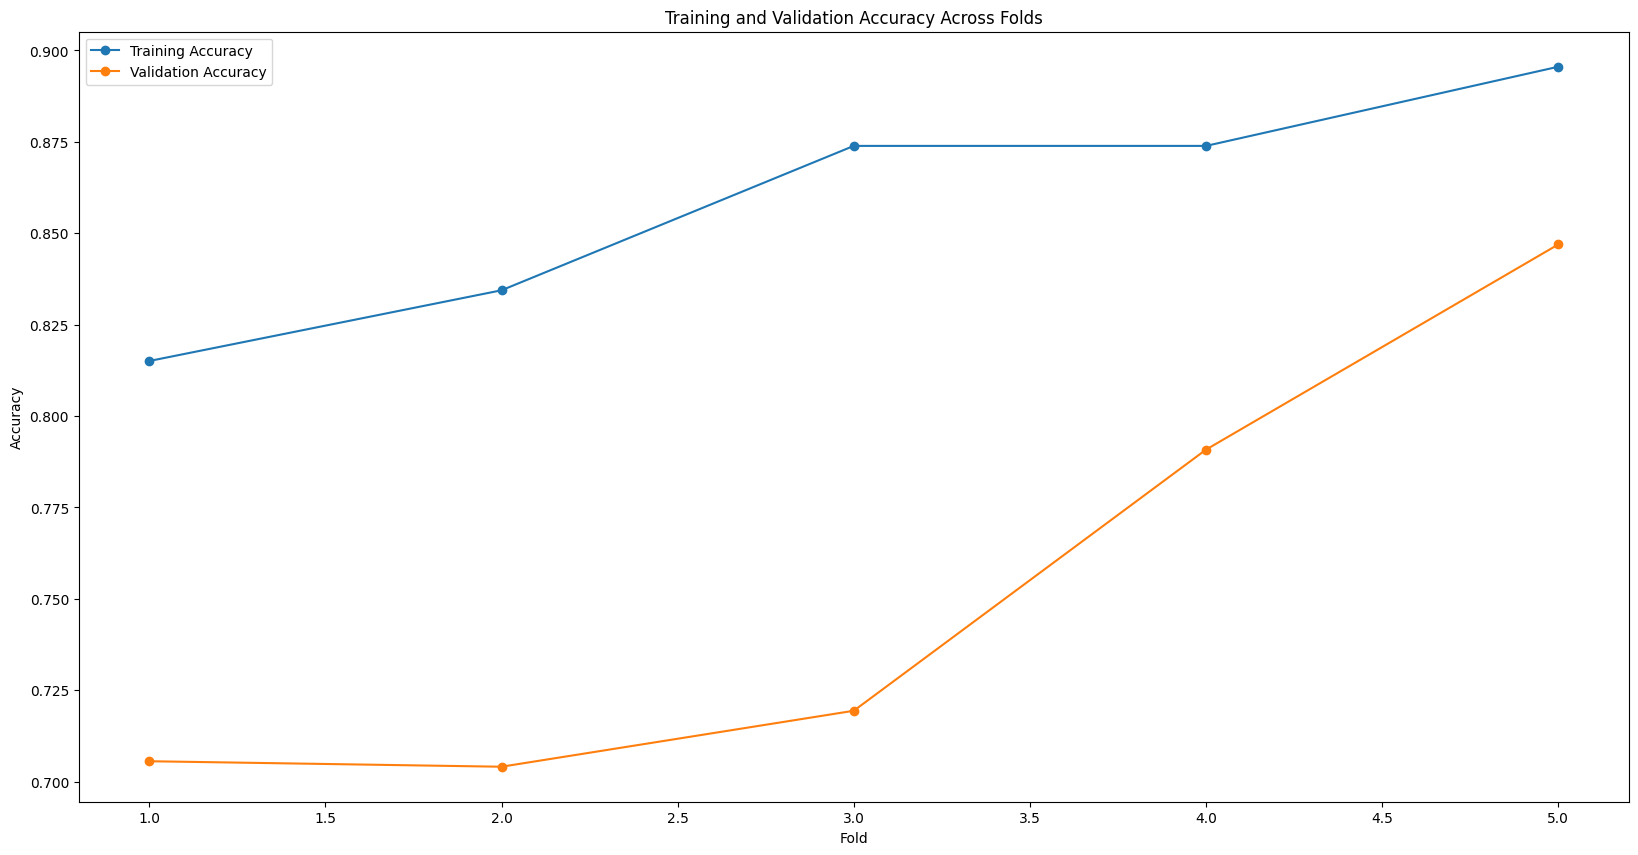

In [27]:
import matplotlib.pyplot as plt
import numpy as np

train_accuracies = []
val_accuracies = []

for fold_history in fold_histories:
    train_accuracies.append(fold_history.history['accuracy'][-1])
    val_accuracies.append(fold_history.history['val_accuracy'][-1])

# Plotting the training and validation accuracy across folds
folds = np.arange(1, len(train_accuracies) + 1)

plt.plot(folds, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(folds, val_accuracies, marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy Across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
y_pred_probs = cnn_model.predict(X_test)

7/7 [==============================] - 0s 19ms/step


In [29]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [30]:
y_pred = []
for probs in y_pred_probs:
  pred = []
  index = np.argmax(probs)
  for i in range(len(probs)):
    if i == index:
      pred.append(np.float32(1.0))
    else:
      pred.append(np.float32(0.0))
  y_pred.append(np.array(pred))

In [31]:
y_pred[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [32]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
print(len(y_pred))
print(len(y_test))

197
197


In [34]:
accuracy = 0
for i in range(len(y_pred)):
  if np.array_equal(y_pred[i],y_test[i]):
    accuracy+=1
accuracy = accuracy/len(y_pred)

In [35]:
accuracy*100

94.41624365482234

In [36]:
import pickle
pickle.dump(cnn_model,open('model.pkl','wb'))

In [37]:
!pip list | grep "keras"

keras                            2.14.0


In [38]:
!pip list | grep "tensorflow"

tensorflow                       2.14.0
tensorflow-datasets              4.9.3
tensorflow-estimator             2.14.0
tensorflow-gcs-config            2.14.0
tensorflow-hub                   0.15.0
tensorflow-io-gcs-filesystem     0.34.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.22.0


In [39]:
!pip freeze > requirements.txt

In [40]:
!python3 --version

Python 3.10.12
